In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
class EEGNet(nn.Module):
    def __init__(self, num_class=2):
        super(EEGNet, self).__init__()
        F1 = 8
        D = 3
        F2 = D * F1
        
        # Layer 1
        self.conv2d = nn.Conv2d(1, F1, (1, 100), padding='same') 
        self.batch_norm1 = nn.BatchNorm2d(F1)
        
        # Layer 2
        self.depthwise_conv = nn.Conv2d(F1, D * F1, (32, 1), groups=F1, padding='same')  # Spatial convolution
        self.batch_norm2 = nn.BatchNorm2d(D * F1)
        self.elu = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.5)
        
        # Layer 3
        self.separable_conv_depth = nn.Conv2d(D * F1, D * F1, (1, 16), groups=D * F1, padding='same')  # Depthwise
        self.separable_conv_point = nn.Conv2d(D * F1, F2, (1, 1), padding='same')  # Pointwise
        self.batch_norm3 = nn.BatchNorm2d(F2)
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layer
        self.flatten = nn.Flatten()
        #self.fc = nn.Linear(F2 * 8, num_class)  # Adjust for final output classes
        self.fc = nn.Linear(6144, num_class) 

    def forward(self, x):
        # Apply all convolutional layers
        x = self.batch_norm1(self.conv2d(x))
        x = self.elu(self.batch_norm2(self.depthwise_conv(x)))
        x = self.dropout1(self.pooling1(x))
        x = self.elu(self.batch_norm3(self.separable_conv_point(self.separable_conv_depth(x))))
        x = self.dropout2(self.pooling2(x))
        
        # Flatten the tensor
        x = self.flatten(x)
        
        #print(f"Shape after flattening: {x.shape}")
        
        # Fully connected layer
        x = self.fc(x)
        return x


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

file = "features/cleaned_epoched_eeg.npy"
raw_data = np.load(file, allow_pickle=True)
print(raw_data.shape)

X = np.stack(raw_data[:, 1])
y = raw_data[:, 0].astype(int)  
y = y - 1 

X = X[:, :, 200 * 2:200 * 6] 
X = X[:, :, 0:-1:3] 

X = (X - np.mean(X)) / np.std(X)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add a channel dimension (1)
y = torch.tensor(y, dtype=torch.long)

print(f'X shape: {X.shape}')  # Should be (660, 1, 32, 267)
print(f'y shape: {y.shape}')  # Should be (660,)

y_binary = (y == 3).long()  # Class 3 becomes "1", all other classes are "0"

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

train_dataset_bin = TensorDataset(X_train_bin, y_train_bin)
val_dataset_bin = TensorDataset(X_val_bin, y_val_bin)
train_loader_bin = DataLoader(train_dataset_bin, batch_size=64, shuffle=True)
val_loader_bin = DataLoader(val_dataset_bin, batch_size=64, shuffle=False)

binary_model = EEGNet(num_class=2).to(device)
binary_loss_fn = nn.CrossEntropyLoss().to(device)
binary_optimizer = optim.NAdam(binary_model.parameters(), lr=0.001, weight_decay=1e-3)

(660, 2)
X shape: torch.Size([660, 1, 32, 267])
y shape: torch.Size([660])


In [4]:
class_counts = torch.bincount(y_train_bin)
print(f"Class distribution in the training set: {class_counts}")

class_counts_val = torch.bincount(y_val_bin)
print(f"Class distribution in the validation set: {class_counts_val}")

Class distribution in the training set: tensor([396, 132])
Class distribution in the validation set: tensor([99, 33])


In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss

In [6]:
#class_counts = torch.bincount(y_train_bin)
#class_weights = 1.0 / class_counts.float()
#class_weights = torch.tensor([1.0, 2.0], dtype=torch.float).to(device)
#class_weights = class_weights.to(device)

#binary_loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
binary_loss_fn = FocalLoss(alpha=2.0, gamma=2.0).to(device)

loss_train_hist = []
acc_train_hist = []
loss_val_hist = []
acc_val_hist = []

num_epochs = 500

best_val_loss = float('inf')
patience = 60  # Stop training if no improvement after 10 epochs
patience_counter = 0

scheduler = torch.optim.lr_scheduler.StepLR(binary_optimizer, step_size=10, gamma=0.1)


for epoch in range(num_epochs):
    binary_model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in train_loader_bin:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = binary_model(inputs)
        loss = binary_loss_fn(outputs, targets)

        # Backward pass
        binary_optimizer.zero_grad()
        loss.backward()
        binary_optimizer.step()

        # Track training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    # Evaluate on validation set
    binary_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader_bin:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = binary_model(inputs)
            loss = binary_loss_fn(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    scheduler.step()

    loss_train_hist.append(train_loss / len(train_loader_bin))
    acc_train_hist.append(correct_train / total_train)
    loss_val_hist.append(val_loss / len(val_loader_bin))
    acc_val_hist.append(correct_val / total_val)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader_bin):.4f}, '
          f'Train Acc: {correct_train/total_train:.4f}, Val Loss: {val_loss/len(val_loader_bin):.4f}, '
          f'Val Acc: {correct_val/total_val:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation improves
    else:
        patience_counter += 1  # Increment patience counter if no improvement
    
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break


C:\Users\TeraForm\anaconda3\envs\eegnet_env\lib\site-packages\torch\nn\modules\conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/500, Train Loss: 0.2626, Train Acc: 0.6818, Val Loss: 0.2934, Val Acc: 0.7500
Epoch 2/500, Train Loss: 0.2275, Train Acc: 0.7519, Val Loss: 0.3760, Val Acc: 0.3864
Epoch 3/500, Train Loss: 0.2419, Train Acc: 0.6989, Val Loss: 0.2435, Val Acc: 0.7424
Epoch 4/500, Train Loss: 0.1466, Train Acc: 0.7595, Val Loss: 0.2095, Val Acc: 0.7424
Epoch 5/500, Train Loss: 0.1471, Train Acc: 0.7689, Val Loss: 0.2037, Val Acc: 0.7652
Epoch 6/500, Train Loss: 0.1304, Train Acc: 0.7860, Val Loss: 0.1530, Val Acc: 0.8030
Epoch 7/500, Train Loss: 0.1386, Train Acc: 0.7822, Val Loss: 0.1330, Val Acc: 0.7652
Epoch 8/500, Train Loss: 0.1638, Train Acc: 0.7917, Val Loss: 0.2887, Val Acc: 0.6894
Epoch 9/500, Train Loss: 0.1057, Train Acc: 0.7898, Val Loss: 0.1639, Val Acc: 0.7576
Epoch 10/500, Train Loss: 0.0951, Train Acc: 0.8201, Val Loss: 0.1572, Val Acc: 0.7652
Epoch 11/500, Train Loss: 0.0955, Train Acc: 0.8277, Val Loss: 0.1549, Val Acc: 0.7727
Epoch 12/500, Train Loss: 0.0888, Train Acc: 0.8239,

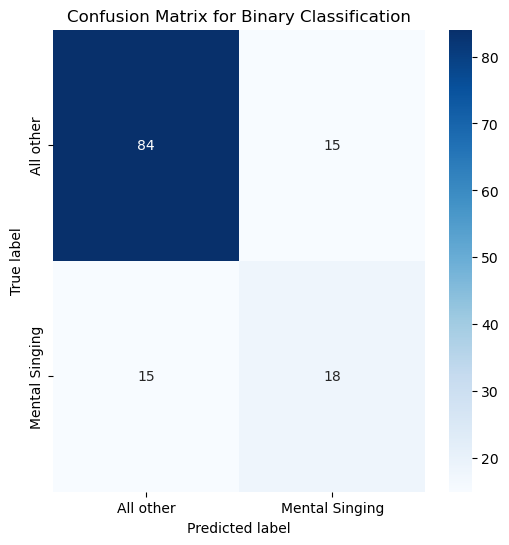

In [7]:
binary_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in val_loader_bin:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = binary_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=['All other', 'Mental Singing'], yticklabels=['All other', 'Mental Singing'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Binary Classification')
plt.show()


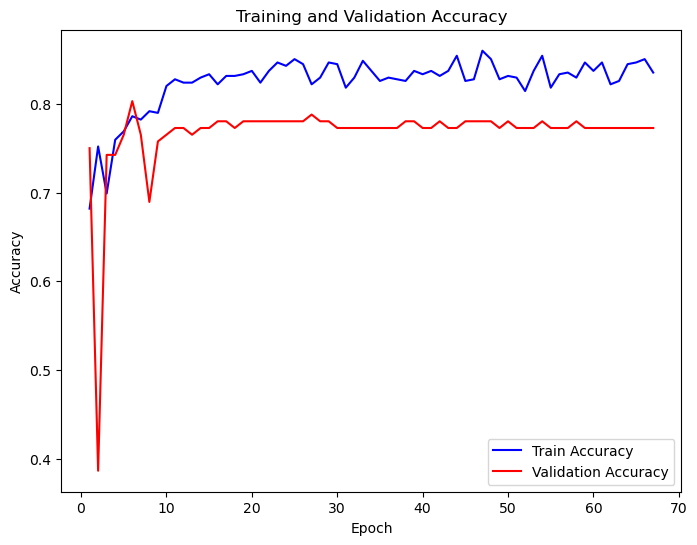

In [10]:
epochs = range(1, len(acc_train_hist) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc_train_hist, 'b', label='Train Accuracy')
plt.plot(epochs, acc_val_hist, 'r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

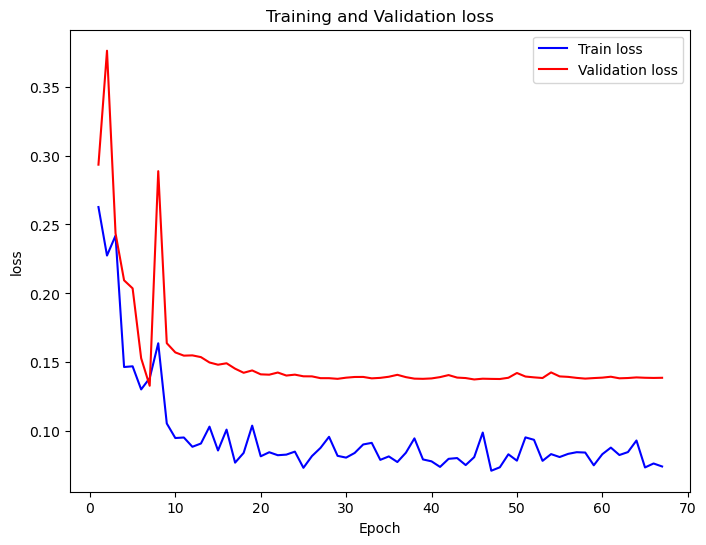

In [11]:
epochs = range(1, len(acc_train_hist) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_train_hist, 'b', label='Train loss')
plt.plot(epochs, loss_val_hist, 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()